#Generate clips
Generate 2-sec + call length clips along with mask files (0's where no call, 1's where call) and save to use as training data. Use all labeled files in round 1.

Output clips to /content/drive/My Drive/MeerkatCallDetector/clips

Save in format:
calltype##_aud.npy
calltype##_mask.npy

In [6]:
#Generate samples for use as training data
#Generate files and store in clips folder

#NOTE: Using SS and RY files for validation not training - as of May 2019 (ari_labels_only = True)

#params
base_dir = '/home/arianasp/meerkat_detector'
ari_labels_only = True
load_labels = True
generate_clips = True
focal = False #whether to run for focal obs recordings from collaring experiment (otherwise run for collar recordings)
focal_megan = False #whether to run on focal obs recordings collected from Megan
validation = True

#Directories
ground_truth_dir = base_dir + '/ground_truth'
code_dir = base_dir + '/dev'
audio_dir = base_dir + '/data/full_recordings' 
focal_megan_dir = '/media/arianasp/Elements/Sound files/Pups VS No Pups'

#Leave one file out for later validation
#validation_file = 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS' #used for collar data
#validation_file = 'HM_VHMM003_SOUNDFOC_20170905_3_label' #used for focal data

#import libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import re
import IPython.display as ipd

#Set path
sys.path.append(code_dir)

#Import library
from meerkat_call_detector_library import *

if(load_labels and not focal_megan):

  #Read in all training data
  ground_truth_files = os.listdir(ground_truth_dir)

  #Remove sound focals or use only sound focals
  if(focal):
    #ground_truth_files = [s for s in ground_truth_files if('SOUNDFOC' in s)]
    ground_truth_files = [s for s in ground_truth_files if('SOUNDFOC' in s)]
  else:
    ground_truth_files = [s for s in ground_truth_files if(not('SOUNDFOC' in s))]
  print(ground_truth_files)
    
  #Remove data from validation file (will be used later) - removed because all SS and RY files will now be validation
  #ground_truth_files = [s for s in ground_truth_files if(not(validation_file in s))]

  #Remove files lableed by other peoples (to use as testing data)
  if(ari_labels_only and not(validation)):
    ground_truth_files = [s for s in ground_truth_files if(("label.csv" in s) or ('label.CSV' in s))]
    
  if(validation):
    ground_truth_files = [s for s in ground_truth_files if(not(("label.csv" in s) or ('label.CSV' in s)))]

  labels_all = pandas.DataFrame()

  for file in ground_truth_files:

    #Read in curent labels for each file
    labels = pandas.read_csv(ground_truth_dir + '/' + file,delimiter='\t')

    #convert times to seconds
    labels['start_time'] = labels['Start'].map(lambda x: hms_to_seconds(x))
    labels['duration'] = labels['Duration'].map(lambda x: hms_to_seconds(x))
    labels['end_time'] = labels['start_time'] + labels['duration']

    #Add columns for label types
    labels['label_type'] = labels['Name'].apply(label_type)
    labels['call_type'] = labels['Name'].apply(call_type_simple)
    labels['focal'] = labels['Name'].apply(caller)

    #Add column for filename
    labels['file'] = file

    #Add None where appropriate
    labels.loc[labels['label_type'] != 'call','call_type'] = None
    labels.loc[labels['label_type'] != 'call','focal'] = None

    labels_all = labels_all.append(labels,ignore_index=True)

  labels = labels_all
  
if(generate_clips and not(focal_megan)):

  #generate 2 sec clips and save to clips folder
  if(focal):
    clips_dir = base_dir + '/clips_foc'
  elif(focal_megan):
    clips_dir = base_dir + '/clips_foc_megan'
  elif(validation):
    clips_dir = base_dir + '/clips_validate'
  else:
    clips_dir = base_dir + '/clips'
  samprate = 8000 

  n_labels = len(labels.index)

  for i in labels.index:
    print(str(i) + '/' + str(n_labels))
    call_type = labels['call_type'][i]
    if(call_type != None):
        t0 = labels['start_time'][i] - 1
        tf = labels['end_time'][i] + 1
        file = labels['file'][i]
        
        if(focal):
          path_aud = audio_dir + '/' + file[0:(len(file)-4)] + '_downsamp.wav'
        else:
          path_aud = audio_dir + '/' + file[0:(len(file)-4)] + '.wav'
        aud, sr = librosa.core.load(path=path_aud,sr=samprate,offset=t0,duration=tf-t0)

        #get mask
        labs_curr = labels[(labels['file']==file) & (labels['start_time']>= t0) & (labels['end_time']<= tf) & (labels['call_type']!= None)]
        nrow = labs_curr.shape[0]
        mask = np.zeros(shape=len(aud))
        for j in labs_curr.index:
          t0_call = np.int(np.round((labs_curr['start_time'][j] - t0)*samprate))
          tf_call = np.int(np.round((labs_curr['end_time'][j] - t0)*samprate))
          if(t0_call < 0):
            t0_call = 0
          mask[t0_call:tf_call] = 1
        clip_file_name = call_type + str(i)
        np.save(clips_dir + '/' + clip_file_name + '_mask.npy',mask)
        np.save(clips_dir + '/' + clip_file_name + '_aud.npy',aud)

  #save list of labels
  fid = open(clips_dir + '/' + 'labels_all.pckl','wb')
  pickle.dump(labels,fid)
  fid.close()

if(generate_clips and focal_megan):
    labels_train_file = '/home/arianasp/meerkat_detector/labels_megan/focal_labels_train.csv'
    wav_dir = '/media/arianasp/Elements/Sound Files/Pups VS No Pups'
    clips_dir = '/home/arianasp/meerkat_detector/clips_foc_megan'
    samprate=8000
    labels = pandas.read_csv(labels_train_file,delimiter=',',dtype=object)

    #Convert European formatted numbers to decimal format
    labels["t0"] = labels["t0"].str.replace(",",".").astype(float)
    labels["tf"] = labels["tf"].str.replace(",",".").astype(float)

    #Loop over all labels and create clips and masks for each
    for i in range(labels.shape[0]):
        print(i)
        filename = labels['filename'][i]
        call_type = labels['type'][i]
        t0 = float(labels['t0'][i]) - 1
        tf = float(labels['tf'][i]) + 1
        iscall = labels['iscall'][i]
        if iscall=='TRUE':
            file_str = filename[0:(len(filename)-4)]
            matches = glob.glob(wav_dir + '/**/[nN][oO] [pP][uU][pP][sS]/**/' + file_str + '_LEFT_8000.[wW][aA][vV]',recursive=True)
            if len(matches)==1 and t0>0:
                path_aud = matches[0]
                aud, sr = librosa.core.load(path=path_aud,sr=samprate,offset=t0,duration=tf-t0)
                labs_curr = labels[(labels['filename']==filename) & (labels['t0']>= t0) & (labels['tf']<= tf) & (labels['iscall']== 'TRUE')]
                if (sum(labs_curr['type'].str.contains('end'))==0) and (sum(labs_curr['type'].str.contains('start'))==0):
                    nrow = labs_curr.shape[0]
                    mask = np.zeros(shape=len(aud))
                    for j in labs_curr.index:
                        t0_call = np.int(np.round((labs_curr['t0'][j] - t0)*samprate))
                        tf_call = np.int(np.round((labs_curr['tf'][j] - t0)*samprate))
                        if(t0_call < 0):
                            t0_call = 0
                        mask[t0_call:tf_call] = 1
                    clip_file_name = call_type + str(i)
                    print(clips_dir + '/' + clip_file_name)
                    print(matches)
                    np.save(clips_dir + '/' + clip_file_name + '_mask.npy',mask)
                    np.save(clips_dir + '/' + clip_file_name + '_aud.npy',aud)

['HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY.csv', 'HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS.csv', 'HM_HTB_R14_file_4_(2017_08_23-06_44_59)_ASWMUX221052._labelSS.csv', 'HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092_label.csv', 'HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092_LABEL_RY.csv', 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv', 'HM_RT_R10_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221102_label.CSV', 'HM_PET_R11_20170903-20170908_file_3_(2017_09_04-05_44_59)_ASWMUX221163_label.csv', 'HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS.csv', 'HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092_LABEL_RY.csv', 'HM_HTB_R14_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221052_label.CSV', 'HM_LT_R07_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221092_SS.csv', 'HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_label.csv', 'HM_

685/9071
686/9071
687/9071
688/9071
689/9071
690/9071
691/9071
692/9071
693/9071
694/9071
695/9071
696/9071
697/9071
698/9071
699/9071
700/9071
701/9071
702/9071
703/9071
704/9071
705/9071
706/9071
707/9071
708/9071
709/9071
710/9071
711/9071
712/9071
713/9071
714/9071
715/9071
716/9071
717/9071
718/9071
719/9071
720/9071
721/9071
722/9071
723/9071
724/9071
725/9071
726/9071
727/9071
728/9071
729/9071
730/9071
731/9071
732/9071
733/9071
734/9071
735/9071
736/9071
737/9071
738/9071
739/9071
740/9071
741/9071
742/9071
743/9071
744/9071
745/9071
746/9071
747/9071
748/9071
749/9071
750/9071
751/9071
752/9071
753/9071
754/9071
755/9071
756/9071
757/9071
758/9071
759/9071
760/9071
761/9071
762/9071
763/9071
764/9071
765/9071
766/9071
767/9071
768/9071
769/9071
770/9071
771/9071
772/9071
773/9071
774/9071
775/9071
776/9071
777/9071
778/9071
779/9071
780/9071
781/9071
782/9071
783/9071
784/9071
785/9071
786/9071
787/9071
788/9071
789/9071
790/9071
791/9071
792/9071
793/9071
794/9071
795/9071
7

1536/9071
1537/9071
1538/9071
1539/9071
1540/9071
1541/9071
1542/9071
1543/9071
1544/9071
1545/9071
1546/9071
1547/9071
1548/9071
1549/9071
1550/9071
1551/9071
1552/9071
1553/9071
1554/9071
1555/9071
1556/9071
1557/9071
1558/9071
1559/9071
1560/9071
1561/9071
1562/9071
1563/9071
1564/9071
1565/9071
1566/9071
1567/9071
1568/9071
1569/9071
1570/9071
1571/9071
1572/9071
1573/9071
1574/9071
1575/9071
1576/9071
1577/9071
1578/9071
1579/9071
1580/9071
1581/9071
1582/9071
1583/9071
1584/9071
1585/9071
1586/9071
1587/9071
1588/9071
1589/9071
1590/9071
1591/9071
1592/9071
1593/9071
1594/9071
1595/9071
1596/9071
1597/9071
1598/9071
1599/9071
1600/9071
1601/9071
1602/9071
1603/9071
1604/9071
1605/9071
1606/9071
1607/9071
1608/9071
1609/9071
1610/9071
1611/9071
1612/9071
1613/9071
1614/9071
1615/9071
1616/9071
1617/9071
1618/9071
1619/9071
1620/9071
1621/9071
1622/9071
1623/9071
1624/9071
1625/9071
1626/9071
1627/9071
1628/9071
1629/9071
1630/9071
1631/9071
1632/9071
1633/9071
1634/9071
1635/9071


2356/9071
2357/9071
2358/9071
2359/9071
2360/9071
2361/9071
2362/9071
2363/9071
2364/9071
2365/9071
2366/9071
2367/9071
2368/9071
2369/9071
2370/9071
2371/9071
2372/9071
2373/9071
2374/9071
2375/9071
2376/9071
2377/9071
2378/9071
2379/9071
2380/9071
2381/9071
2382/9071
2383/9071
2384/9071
2385/9071
2386/9071
2387/9071
2388/9071
2389/9071
2390/9071
2391/9071
2392/9071
2393/9071
2394/9071
2395/9071
2396/9071
2397/9071
2398/9071
2399/9071
2400/9071
2401/9071
2402/9071
2403/9071
2404/9071
2405/9071
2406/9071
2407/9071
2408/9071
2409/9071
2410/9071
2411/9071
2412/9071
2413/9071
2414/9071
2415/9071
2416/9071
2417/9071
2418/9071
2419/9071
2420/9071
2421/9071
2422/9071
2423/9071
2424/9071
2425/9071
2426/9071
2427/9071
2428/9071
2429/9071
2430/9071
2431/9071
2432/9071
2433/9071
2434/9071
2435/9071
2436/9071
2437/9071
2438/9071
2439/9071
2440/9071
2441/9071
2442/9071
2443/9071
2444/9071
2445/9071
2446/9071
2447/9071
2448/9071
2449/9071
2450/9071
2451/9071
2452/9071
2453/9071
2454/9071
2455/9071


3177/9071
3178/9071
3179/9071
3180/9071
3181/9071
3182/9071
3183/9071
3184/9071
3185/9071
3186/9071
3187/9071
3188/9071
3189/9071
3190/9071
3191/9071
3192/9071
3193/9071
3194/9071
3195/9071
3196/9071
3197/9071
3198/9071
3199/9071
3200/9071
3201/9071
3202/9071
3203/9071
3204/9071
3205/9071
3206/9071
3207/9071
3208/9071
3209/9071
3210/9071
3211/9071
3212/9071
3213/9071
3214/9071
3215/9071
3216/9071
3217/9071
3218/9071
3219/9071
3220/9071
3221/9071
3222/9071
3223/9071
3224/9071
3225/9071
3226/9071
3227/9071
3228/9071
3229/9071
3230/9071
3231/9071
3232/9071
3233/9071
3234/9071
3235/9071
3236/9071
3237/9071
3238/9071
3239/9071
3240/9071
3241/9071
3242/9071
3243/9071
3244/9071
3245/9071
3246/9071
3247/9071
3248/9071
3249/9071
3250/9071
3251/9071
3252/9071
3253/9071
3254/9071
3255/9071
3256/9071
3257/9071
3258/9071
3259/9071
3260/9071
3261/9071
3262/9071
3263/9071
3264/9071
3265/9071
3266/9071
3267/9071
3268/9071
3269/9071
3270/9071
3271/9071
3272/9071
3273/9071
3274/9071
3275/9071
3276/9071


3997/9071
3998/9071
3999/9071
4000/9071
4001/9071
4002/9071
4003/9071
4004/9071
4005/9071
4006/9071
4007/9071
4008/9071
4009/9071
4010/9071
4011/9071
4012/9071
4013/9071
4014/9071
4015/9071
4016/9071
4017/9071
4018/9071
4019/9071
4020/9071
4021/9071
4022/9071
4023/9071
4024/9071
4025/9071
4026/9071
4027/9071
4028/9071
4029/9071
4030/9071
4031/9071
4032/9071
4033/9071
4034/9071
4035/9071
4036/9071
4037/9071
4038/9071
4039/9071
4040/9071
4041/9071
4042/9071
4043/9071
4044/9071
4045/9071
4046/9071
4047/9071
4048/9071
4049/9071
4050/9071
4051/9071
4052/9071
4053/9071
4054/9071
4055/9071
4056/9071
4057/9071
4058/9071
4059/9071
4060/9071
4061/9071
4062/9071
4063/9071
4064/9071
4065/9071
4066/9071
4067/9071
4068/9071
4069/9071
4070/9071
4071/9071
4072/9071
4073/9071
4074/9071
4075/9071
4076/9071
4077/9071
4078/9071
4079/9071
4080/9071
4081/9071
4082/9071
4083/9071
4084/9071
4085/9071
4086/9071
4087/9071
4088/9071
4089/9071
4090/9071
4091/9071
4092/9071
4093/9071
4094/9071
4095/9071
4096/9071


4817/9071
4818/9071
4819/9071
4820/9071
4821/9071
4822/9071
4823/9071
4824/9071
4825/9071
4826/9071
4827/9071
4828/9071
4829/9071
4830/9071
4831/9071
4832/9071
4833/9071
4834/9071
4835/9071
4836/9071
4837/9071
4838/9071
4839/9071
4840/9071
4841/9071
4842/9071
4843/9071
4844/9071
4845/9071
4846/9071
4847/9071
4848/9071
4849/9071
4850/9071
4851/9071
4852/9071
4853/9071
4854/9071
4855/9071
4856/9071
4857/9071
4858/9071
4859/9071
4860/9071
4861/9071
4862/9071
4863/9071
4864/9071
4865/9071
4866/9071
4867/9071
4868/9071
4869/9071
4870/9071
4871/9071
4872/9071
4873/9071
4874/9071
4875/9071
4876/9071
4877/9071
4878/9071
4879/9071
4880/9071
4881/9071
4882/9071
4883/9071
4884/9071
4885/9071
4886/9071
4887/9071
4888/9071
4889/9071
4890/9071
4891/9071
4892/9071
4893/9071
4894/9071
4895/9071
4896/9071
4897/9071
4898/9071
4899/9071
4900/9071
4901/9071
4902/9071
4903/9071
4904/9071
4905/9071
4906/9071
4907/9071
4908/9071
4909/9071
4910/9071
4911/9071
4912/9071
4913/9071
4914/9071
4915/9071
4916/9071


5637/9071
5638/9071
5639/9071
5640/9071
5641/9071
5642/9071
5643/9071
5644/9071
5645/9071
5646/9071
5647/9071
5648/9071
5649/9071
5650/9071
5651/9071
5652/9071
5653/9071
5654/9071
5655/9071
5656/9071
5657/9071
5658/9071
5659/9071
5660/9071
5661/9071
5662/9071
5663/9071
5664/9071
5665/9071
5666/9071
5667/9071
5668/9071
5669/9071
5670/9071
5671/9071
5672/9071
5673/9071
5674/9071
5675/9071
5676/9071
5677/9071
5678/9071
5679/9071
5680/9071
5681/9071
5682/9071
5683/9071
5684/9071
5685/9071
5686/9071
5687/9071
5688/9071
5689/9071
5690/9071
5691/9071
5692/9071
5693/9071
5694/9071
5695/9071
5696/9071
5697/9071
5698/9071
5699/9071
5700/9071
5701/9071
5702/9071
5703/9071
5704/9071
5705/9071
5706/9071
5707/9071
5708/9071
5709/9071
5710/9071
5711/9071
5712/9071
5713/9071
5714/9071
5715/9071
5716/9071
5717/9071
5718/9071
5719/9071
5720/9071
5721/9071
5722/9071
5723/9071
5724/9071
5725/9071
5726/9071
5727/9071
5728/9071
5729/9071
5730/9071
5731/9071
5732/9071
5733/9071
5734/9071
5735/9071
5736/9071


6457/9071
6458/9071
6459/9071
6460/9071
6461/9071
6462/9071
6463/9071
6464/9071
6465/9071
6466/9071
6467/9071
6468/9071
6469/9071
6470/9071
6471/9071
6472/9071
6473/9071
6474/9071
6475/9071
6476/9071
6477/9071
6478/9071
6479/9071
6480/9071
6481/9071
6482/9071
6483/9071
6484/9071
6485/9071
6486/9071
6487/9071
6488/9071
6489/9071
6490/9071
6491/9071
6492/9071
6493/9071
6494/9071
6495/9071
6496/9071
6497/9071
6498/9071
6499/9071
6500/9071
6501/9071
6502/9071
6503/9071
6504/9071
6505/9071
6506/9071
6507/9071
6508/9071
6509/9071
6510/9071
6511/9071
6512/9071
6513/9071
6514/9071
6515/9071
6516/9071
6517/9071
6518/9071
6519/9071
6520/9071
6521/9071
6522/9071
6523/9071
6524/9071
6525/9071
6526/9071
6527/9071
6528/9071
6529/9071
6530/9071
6531/9071
6532/9071
6533/9071
6534/9071
6535/9071
6536/9071
6537/9071
6538/9071
6539/9071
6540/9071
6541/9071
6542/9071
6543/9071
6544/9071
6545/9071
6546/9071
6547/9071
6548/9071
6549/9071
6550/9071
6551/9071
6552/9071
6553/9071
6554/9071
6555/9071
6556/9071


7277/9071
7278/9071
7279/9071
7280/9071
7281/9071
7282/9071
7283/9071
7284/9071
7285/9071
7286/9071
7287/9071
7288/9071
7289/9071
7290/9071
7291/9071
7292/9071
7293/9071
7294/9071
7295/9071
7296/9071
7297/9071
7298/9071
7299/9071
7300/9071
7301/9071
7302/9071
7303/9071
7304/9071
7305/9071
7306/9071
7307/9071
7308/9071
7309/9071
7310/9071
7311/9071
7312/9071
7313/9071
7314/9071
7315/9071
7316/9071
7317/9071
7318/9071
7319/9071
7320/9071
7321/9071
7322/9071
7323/9071
7324/9071
7325/9071
7326/9071
7327/9071
7328/9071
7329/9071
7330/9071
7331/9071
7332/9071
7333/9071
7334/9071
7335/9071
7336/9071
7337/9071
7338/9071
7339/9071
7340/9071
7341/9071
7342/9071
7343/9071
7344/9071
7345/9071
7346/9071
7347/9071
7348/9071
7349/9071
7350/9071
7351/9071
7352/9071
7353/9071
7354/9071
7355/9071
7356/9071
7357/9071
7358/9071
7359/9071
7360/9071
7361/9071
7362/9071
7363/9071
7364/9071
7365/9071
7366/9071
7367/9071
7368/9071
7369/9071
7370/9071
7371/9071
7372/9071
7373/9071
7374/9071
7375/9071
7376/9071


8097/9071
8098/9071
8099/9071
8100/9071
8101/9071
8102/9071
8103/9071
8104/9071
8105/9071
8106/9071
8107/9071
8108/9071
8109/9071
8110/9071
8111/9071
8112/9071
8113/9071
8114/9071
8115/9071
8116/9071
8117/9071
8118/9071
8119/9071
8120/9071
8121/9071
8122/9071
8123/9071
8124/9071
8125/9071
8126/9071
8127/9071
8128/9071
8129/9071
8130/9071
8131/9071
8132/9071
8133/9071
8134/9071
8135/9071
8136/9071
8137/9071
8138/9071
8139/9071
8140/9071
8141/9071
8142/9071
8143/9071
8144/9071
8145/9071
8146/9071
8147/9071
8148/9071
8149/9071
8150/9071
8151/9071
8152/9071
8153/9071
8154/9071
8155/9071
8156/9071
8157/9071
8158/9071
8159/9071
8160/9071
8161/9071
8162/9071
8163/9071
8164/9071
8165/9071
8166/9071
8167/9071
8168/9071
8169/9071
8170/9071
8171/9071
8172/9071
8173/9071
8174/9071
8175/9071
8176/9071
8177/9071
8178/9071
8179/9071
8180/9071
8181/9071
8182/9071
8183/9071
8184/9071
8185/9071
8186/9071
8187/9071
8188/9071
8189/9071
8190/9071
8191/9071
8192/9071
8193/9071
8194/9071
8195/9071
8196/9071


8917/9071
8918/9071
8919/9071
8920/9071
8921/9071
8922/9071
8923/9071
8924/9071
8925/9071
8926/9071
8927/9071
8928/9071
8929/9071
8930/9071
8931/9071
8932/9071
8933/9071
8934/9071
8935/9071
8936/9071
8937/9071
8938/9071
8939/9071
8940/9071
8941/9071
8942/9071
8943/9071
8944/9071
8945/9071
8946/9071
8947/9071
8948/9071
8949/9071
8950/9071
8951/9071
8952/9071
8953/9071
8954/9071
8955/9071
8956/9071
8957/9071
8958/9071
8959/9071
8960/9071
8961/9071
8962/9071
8963/9071
8964/9071
8965/9071
8966/9071
8967/9071
8968/9071
8969/9071
8970/9071
8971/9071
8972/9071
8973/9071
8974/9071
8975/9071
8976/9071
8977/9071
8978/9071
8979/9071
8980/9071
8981/9071
8982/9071
8983/9071
8984/9071
8985/9071
8986/9071
8987/9071
8988/9071
8989/9071
8990/9071
8991/9071
8992/9071
8993/9071
8994/9071
8995/9071
8996/9071
8997/9071
8998/9071
8999/9071
9000/9071
9001/9071
9002/9071
9003/9071
9004/9071
9005/9071
9006/9071
9007/9071
9008/9071
9009/9071
9010/9071
9011/9071
9012/9071
9013/9071
9014/9071
9015/9071
9016/9071


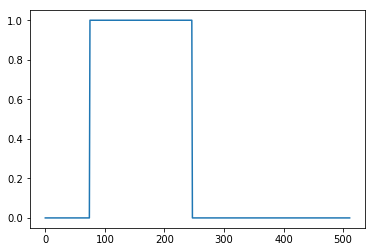

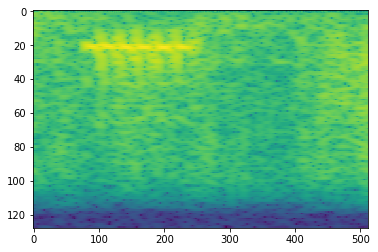

In [23]:
files = os.listdir(clips_dir)
X,y = generate_sample_call(files,clips_dir,call_type=None,mel=False)
plt.plot(y)
plt.show()
plt.imshow(X.T,aspect='auto')
plt.show()

In [11]:
print(labels)

      Unnamed: 0          t0          tf                   label  \
0              1   16.532643   16.532643                   START   
1              2   47.542569   47.542569          NN: VHMM003 2M   
2              3   57.451384   58.420725             AGG VHMF004   
3              4   61.571082   61.571082        NN: VHMF004 NEXT   
4              5  105.200387  105.200387        NN: VHMM002 NEXT   
5              6  159.860429  159.860429  NN: VHMM002+VHMM003 1M   
6              7  394.254629  394.427405                  CC1 SC   
7              8  597.513247  597.513247          NN: VHMM002 1M   
8              9  649.644477  649.644477                     END   
9             10   15.012303   15.012303                   START   
10            11  120.502531  120.502531                   PAUSE   
11            12  123.599209  123.599209                  RESUME   
12            13  180.163262  180.163262                   PAUSE   
13            14  181.400147  181.400147        

In [15]:
labels['t0'] > 20

0        False
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9        False
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24       False
25       False
26       False
27       False
28       False
29        True
         ...  
30002     True
30003     True
30004     True
30005     True
30006     True
30007     True
30008     True
30009     True
30010     True
30011     True
30012     True
30013     True
30014     True
30015     True
30016     True
30017     True
30018     True
30019     True
30020     True
30021     True
30022     True
30023     True
30024     True
30025     True
30026     True
30027     True
30028     True
30029     True
30030     True
30031     True
Name: t0, Length: 30032, dtype: bool